In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rnapark","key":"f766d3a80003b91cb04f4e4633ffd077"}'}

In [2]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list

ref                                                             title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
wardabilal/spotify-global-music-dataset-20092025                Spotify Global Music Dataset (2009–2025)               1289021  2025-11-11 09:43:05.933000           5109        104  1.0              
sadiajavedd/students-academic-performance-dataset               Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000          10847        273  1.0              
kundanbedmutha/customer-sentiment-dataset                       Customer Sentiment Dataset                              296232  2025-11-19 08:18:50.493000            995         27  1.0              


In [3]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

plant_pathology_2020_fgvc7_path = kagglehub.competition_download('plant-pathology-2020-fgvc7')
rnapark_resnet18_f37072fd_pth_path = kagglehub.dataset_download('rnapark/resnet18-f37072fd-pth')
rnapark_resnet34_b627a593_pth_path = kagglehub.dataset_download('rnapark/resnet34-b627a593-pth')

print('Data source import complete.')


100%|██████████| 779M/779M [00:35<00:00, 22.8MB/s]

Extracting files...


100%|██████████| 41.4M/41.4M [00:03<00:00, 14.2MB/s]

Extracting files...


100%|██████████| 77.2M/77.2M [00:04<00:00, 18.3MB/s]

Extracting files...


Data source import complete.


# Load data

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from PIL import Image
import os

class AppleDataset(Dataset):
  def __init__(self, csv_path, images, transform=None, is_test=False):
    self.data = pd.read_csv(csv_path)
    self.images = images
    self.transform = transform
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    row = self.data.iloc[idx]
    image_path = os.path.join(self.images, row['image_id']+".jpg")
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    if self.is_test:
      return image
    else:
      label = row[['healthy', 'multiple_diseases', 'rust', 'scab']].values.astype("float32")
      return image, label


# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
# file paths
base_dir = plant_pathology_2020_fgvc7_path
train_csv = base_dir + "/train.csv"
test_csv  = base_dir + "/test.csv"
images = base_dir + "/images"

train_data = AppleDataset(train_csv, images, transform=None)
test_data  = AppleDataset(test_csv, images, transform=None, is_test=True)

# Commented out the below because transforms are not defined until later
# train_set, val_set = random_split(train_data, [0.8, 0.2])

# # Prepare DataLoaders
# train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
# val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# print("Data loaded successfully!")
# print("Train batches:", len(train_loader))
# print("Val batches:", len(val_loader))
# print("Test batches:", len(test_loader))

# images, labels = next(iter(train_loader))
# print(images.shape)  # (64, 3, H, W)
# print(labels.shape)  # (64, 4)


## Helper to visualize training curves

In [7]:
from matplotlib import pyplot as plt

# Helper function to visualize performance during training
def plot_training_curves(train_losses, val_accuracies):
    """Plot training loss and validation accuracy curves.

    Parameters
    ----------
    train_losses : list of float
        Training loss values for each epoch. Should have one value per epoch.
    val_accuracies : list of float
        Validation accuracy values for each epoch. Should have same length as
        train_losses. Accuracy values should be between 0 and 1 (or 0 and 100
        if using percentages).

    Returns
    -------
    None
        Displays matplotlib figure with two subplots showing training curves.

    Examples
    --------
    >>> train_losses = [0.8, 0.6, 0.4, 0.3, 0.2]
    >>> val_accuracies = [0.75, 0.80, 0.85, 0.87, 0.88]
    >>> plot_training_curves(train_losses, val_accuracies)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(train_losses)
    ax1.set_title('Training Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(val_accuracies)
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Define training loop, evaluation loop

In [8]:
# Define train/test loop

def mixup_data(x, y, alpha=0.2):
    """Returns mixed inputs, pairs of targets, and lambda."""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def train_loop(
        dataloader,
        model,
        loss_fn,
        optimizer,
        device,
        smoothing=0.0,
        grad_clip=1.0,
        use_mixup=True,
        mixup_alpha=0.2
    ):

    model.train()
    total_loss = 0.0

    for X, y in dataloader:
        X = X.to(device)
        y = y.float().to(device)
        y_smooth = y * (1 - smoothing) + (1 - y) * smoothing

        # MixUp augmentation
        if use_mixup:
            X, y_a, y_b, lam = mixup_data(X, y_smooth, alpha=mixup_alpha)

            # Apply label smoothing AFTER mixup
            y_a = y_a * (1 - smoothing) + (1 - y_a) * smoothing
            y_b = y_b * (1 - smoothing) + (1 - y_b) * smoothing

            pred = model(X)
            #loss = lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
            loss = lam * loss_fn(pred, y_a) + (1 - lam) * loss_fn(pred, y_b)
        else:
            # Only smoothing if NOT using mixup
            y_smooth = y * (1 - smoothing) + (1 - y) * smoothing
            pred = model(X)
            loss = loss_fn(pred, y_smooth)

        optimizer.zero_grad()
        loss.backward()

        # gradient clipping
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
def evaluate_model(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_predictions_sum = 0, 0
    num_labels = 4 # Number of output labels in our dataset

    model.eval()
    with torch.no_grad():
      for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X) # These are logits
        test_loss += loss_fn(pred, y).item()

        # FIX: Calculate accuracy for multi-label classification
        # Apply sigmoid to logits to get probabilities
        probabilities = torch.sigmoid(pred)
        # Threshold probabilities to get binary predictions (0 or 1)
        predicted_labels = (probabilities > 0.5).float()
        # Count total correct individual label predictions (TP + TN)
        correct_predictions_sum += (predicted_labels == y).float().sum().item()

    test_loss = test_loss / num_batches
    # Calculate overall accuracy as the ratio of correctly predicted individual labels
    # to the total possible individual labels (num_samples * num_labels)
    total_possible_labels = size * num_labels
    accuracy = correct_predictions_sum / total_possible_labels
    return test_loss, accuracy

def predict_loop(loader, model, device):
    model.eval()
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities for each class

            all_labels.append(labels.cpu())
            all_probs.append(probs.cpu())

    return torch.cat(all_labels, dim=0), torch.cat(all_probs, dim=0)

def predict_test_loop(loader, model, device):
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            if isinstance(batch, (list, tuple)):
                images = batch[0]
            else:
                images = batch

            images = images.to(device)

            outputs = model(images)
            probs = torch.sigmoid(outputs)  # Raw probabilities

            all_probs.append(probs.cpu())

    return torch.cat(all_probs, dim=0)


# Baseline model - Transfer learning by feature extraction
- only changing the output layer of the model, leaving all parameters prior to the final layer unchanged
- freezing early layers and only training the final classifier

In [9]:
# # Run baseline model
# from torchvision import models
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor()
# ])

# # Kaggle doesn't allow downloads from internet
# #model = models.resnet18(weights='DEFAULT')
# model = models.resnet18(weights=None)
# state_dict = torch.load("/kaggle/input/resnet18-f37072fd-pth/resnet18-f37072fd.pth", map_location="cpu")
# model.load_state_dict(state_dict)

# # Freeze existing model parameters
# for param in model.parameters():
#     param.requires_grad = False

# # 4 possible labels, final classification layer
# model.fc = torch.nn.Linear(model.fc.in_features, 4)

# # Using BCEWithLogitsLoss for multi-label classification
# loss_fn = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# print(f"Using device: {device}")

# train_losses = []
# val_accuracies = []
# epochs = 15
# patience = 3
# best_val_accuracy = 0
# epochs_without_improvement = 0

# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loss = train_loop(train_loader, model, loss_fn, optimizer, device)
#     train_losses.append(train_loss)
#     val_loss, val_accuracy = evaluate_model(val_loader, model, loss_fn, device)
#     val_accuracies.append(val_accuracy)
#     print(f"Training loss: {train_loss:>7f}, Validation loss: {val_loss:>7f}, Validation accuracy: {val_accuracy:>7f}")
#     # Check for early stopping
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         epochs_without_improvement = 0
#     else:
#         epochs_without_improvement += 1
#         if epochs_without_improvement >= patience:
#             print(f"Early stopping at epoch {t+1}")
#             break

# plot_training_curves(train_losses, val_accuracies)

In [10]:
# # Generate predictions for the test_loader
# predictions = predict_loop(test_loader, model, device)
# print("Predictions generated successfully!")
# print("Shape of predictions:", predictions.shape)
# print("Example predictions (probabilities for the first 5 samples):\n", predictions[:5])

# Improving model with fine tuning

With this method, we start with original pretrained ResNet model and replace the output layer as before, but this time **do not** freeze any of the other parameters.

Currently implemented
- [x] Regularization techniques to prevent overfitting(L2 weight decay because most features seem relevant, no need for sparsity)
- [x] Hyperparameter tuning using validation(CV)
- [x] Label smoothing
- [ ] Feature selection
- [x] Learning rate scheduling/decay
- [ ] Compared multiple optimizers(AdamW?)
- [x] Data augmentation(RandomResizedCrop, HorizontalFlip, ColorJitter,AutoAugment)
- [ ] 2-phase training - unfreeze last two blocks and lower LR

Try
- [ ] Increasing epochs to 20, data augmentation = needs more time to learn
- [ ] Test-time augmentation?

In [11]:
def apply_thresholding(probs, thresholds):
    """
    Apply thresholds to the predicted probabilities.
    Args:
    - probs: The predicted probabilities for each class (shape: [batch_size, num_classes])
    - thresholds: The threshold value for each class (shape: [num_classes])

    Returns:
    - preds: The predicted class labels after applying thresholds (shape: [batch_size, num_classes])
    """
    # Initialize an array to store the predictions for each sample
    preds = torch.zeros_like(probs, dtype=torch.long)

    for i in range(probs.shape[0]):  # Iterate over each sample in the batch
        for c in range(probs.shape[1]):  # Iterate over each class
            if probs[i, c] > thresholds[c]:  # Check if the probability exceeds the threshold
                preds[i, c] = 1  # Set the class prediction to 1 (indicating the class is selected)

    # For each sample, choose the class with the maximum probability if no class exceeds threshold
    preds = torch.argmax(probs, dim=1)  # Use the highest probability class if no threshold is surpassed

    return preds

## Defining visualizations for evaluation

In [12]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score, precision_recall_fscore_support

def plot_confusion_matrix(y_true, y_pred, class_names):
    # Generate a confusion matrix for each class in a one-vs-rest manner
    for i, class_name in enumerate(class_names):
        # For each class, consider it as positive and all others as negative
        true_labels = y_true[:, i]
        pred_labels = y_pred[:, i]
        cm = confusion_matrix(true_labels, pred_labels)

        # Extract metrics
        tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0) # Handle cases where a class might not be present
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        print(f"\nMetrics for class: {class_name}")
        print(f"  True Positives (TP): {tp}")
        print(f"  False Positives (FP): {fp}")
        print(f"  False Negatives (FN): {fn}")
        print(f"  True Negatives (TN): {tn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")

        # Calculate and print F1-score
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
        print(f"  F1-score: {f1_score:.4f}")

        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=[f'Not {class_name}', class_name],
                    yticklabels=[f'Not {class_name}', class_name])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix for {class_name}')
        plt.show()

def plot_precision_recall_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
        plt.plot(recall, precision, label=f'{class_names[i]}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.show()

def plot_roc_curve(y_true, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()


Training fold 1...
Epoch 1/15 - Fold 1
Training Loss: 1.0272, Validation Loss: 0.9635, Validation Accuracy: 0.7767
Epoch 2/15 - Fold 1
Training Loss: 0.9189, Validation Loss: 0.8654, Validation Accuracy: 0.8582
Epoch 3/15 - Fold 1
Training Loss: 0.8310, Validation Loss: 0.7403, Validation Accuracy: 0.8993
Epoch 4/15 - Fold 1
Training Loss: 0.7414, Validation Loss: 0.6333, Validation Accuracy: 0.9171
Epoch 5/15 - Fold 1
Training Loss: 0.6106, Validation Loss: 0.5239, Validation Accuracy: 0.9315
Epoch 6/15 - Fold 1
Training Loss: 0.5081, Validation Loss: 0.4446, Validation Accuracy: 0.9459
Epoch 7/15 - Fold 1
Training Loss: 0.5134, Validation Loss: 0.4197, Validation Accuracy: 0.9459
Epoch 8/15 - Fold 1
Training Loss: 0.4107, Validation Loss: 0.3956, Validation Accuracy: 0.9548
Epoch 9/15 - Fold 1
Training Loss: 0.2971, Validation Loss: 0.3449, Validation Accuracy: 0.9616
Epoch 10/15 - Fold 1
Training Loss: 0.3888, Validation Loss: 0.3728, Validation Accuracy: 0.9671
Epoch 11/15 - Fold 

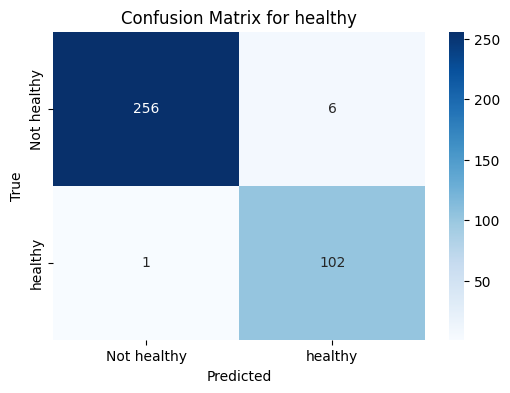


Metrics for class: multiple_diseases
  True Positives (TP): 7
  False Positives (FP): 4
  False Negatives (FN): 11
  True Negatives (TN): 343
  Precision: 0.6364
  Recall: 0.3889
  F1-score: 0.4828


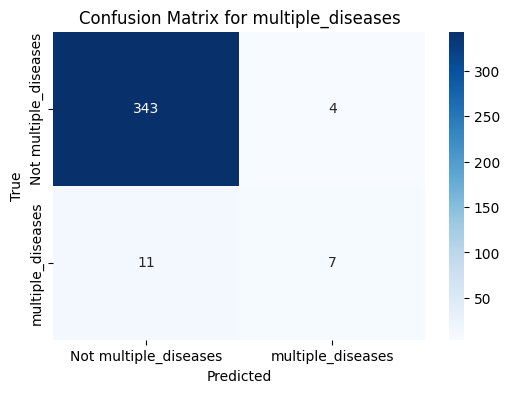


Metrics for class: rust
  True Positives (TP): 123
  False Positives (FP): 9
  False Negatives (FN): 2
  True Negatives (TN): 231
  Precision: 0.9318
  Recall: 0.9840
  F1-score: 0.9572


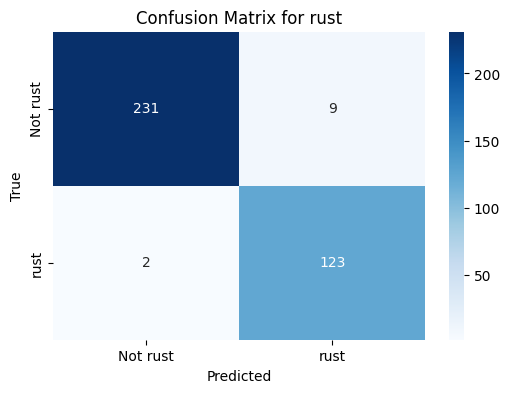


Metrics for class: scab
  True Positives (TP): 115
  False Positives (FP): 7
  False Negatives (FN): 4
  True Negatives (TN): 239
  Precision: 0.9426
  Recall: 0.9664
  F1-score: 0.9544


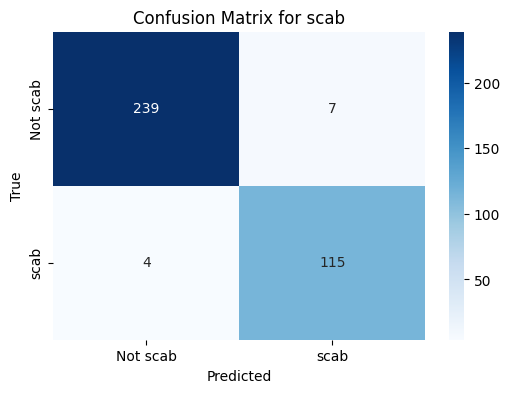

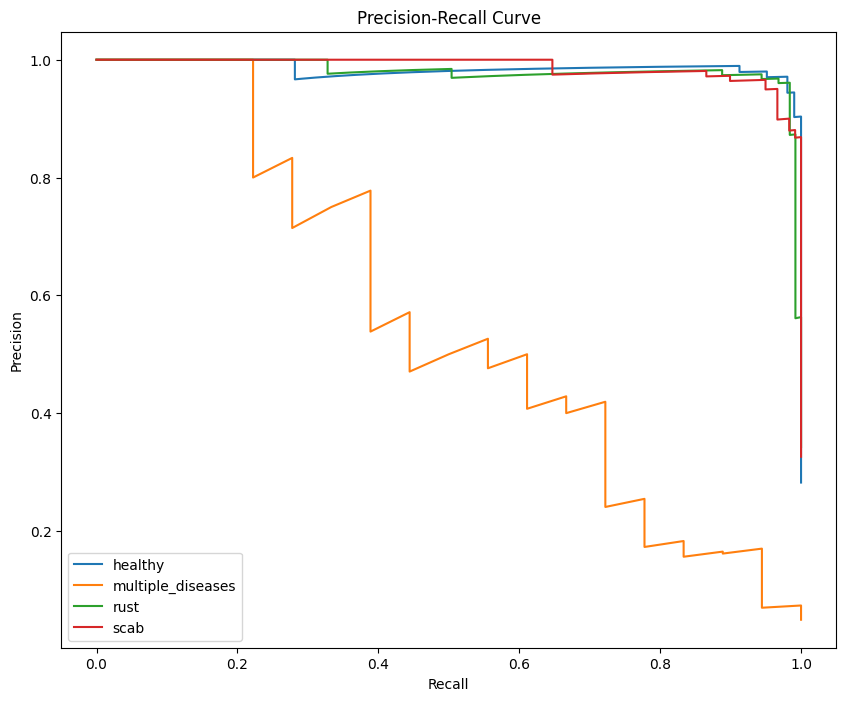

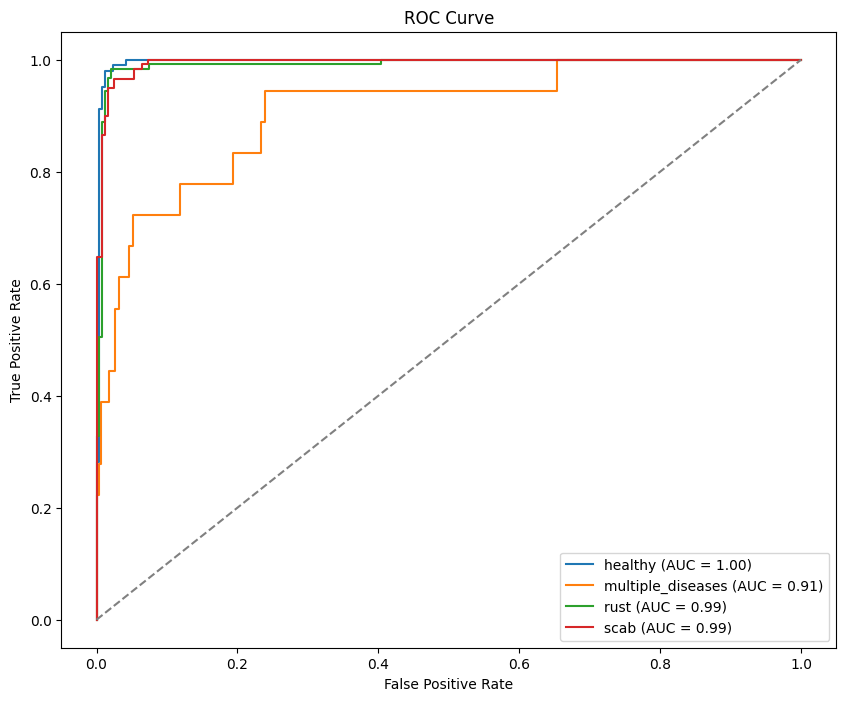


Training fold 2...
Epoch 1/15 - Fold 2
Training Loss: 1.0159, Validation Loss: 0.9624, Validation Accuracy: 0.7548
Epoch 2/15 - Fold 2
Training Loss: 0.9387, Validation Loss: 0.8733, Validation Accuracy: 0.8221
Epoch 3/15 - Fold 2
Training Loss: 0.8360, Validation Loss: 0.7548, Validation Accuracy: 0.8695
Epoch 4/15 - Fold 2
Training Loss: 0.7529, Validation Loss: 0.6379, Validation Accuracy: 0.9148
Epoch 5/15 - Fold 2
Training Loss: 0.6299, Validation Loss: 0.5175, Validation Accuracy: 0.9361
Epoch 6/15 - Fold 2
Training Loss: 0.5579, Validation Loss: 0.4484, Validation Accuracy: 0.9409
Epoch 7/15 - Fold 2
Training Loss: 0.5045, Validation Loss: 0.4015, Validation Accuracy: 0.9512
Epoch 8/15 - Fold 2
Training Loss: 0.3965, Validation Loss: 0.3732, Validation Accuracy: 0.9609
Epoch 9/15 - Fold 2
Training Loss: 0.3865, Validation Loss: 0.3798, Validation Accuracy: 0.9643
Epoch 10/15 - Fold 2
Training Loss: 0.3398, Validation Loss: 0.3824, Validation Accuracy: 0.9677
Epoch 11/15 - Fold 

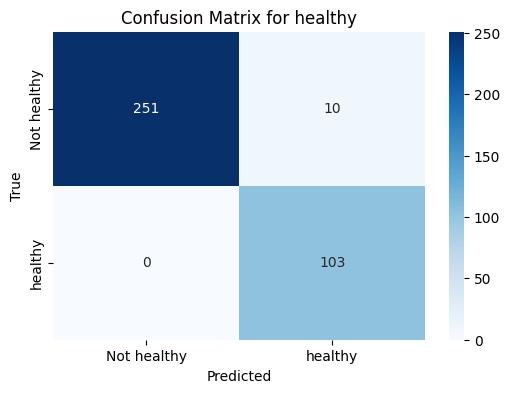


Metrics for class: multiple_diseases
  True Positives (TP): 9
  False Positives (FP): 6
  False Negatives (FN): 9
  True Negatives (TN): 340
  Precision: 0.6000
  Recall: 0.5000
  F1-score: 0.5455


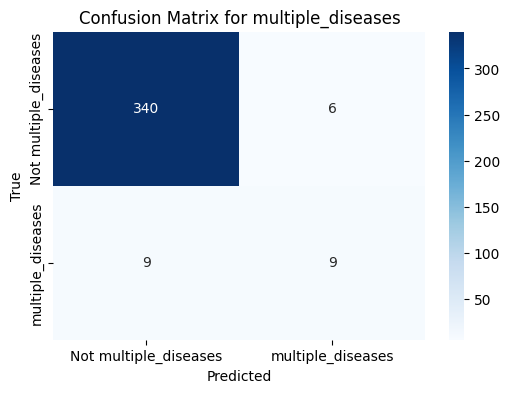


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 5
  False Negatives (FN): 0
  True Negatives (TN): 235
  Precision: 0.9612
  Recall: 1.0000
  F1-score: 0.9802


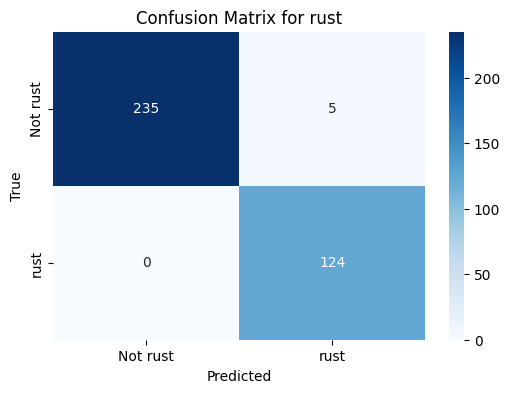


Metrics for class: scab
  True Positives (TP): 116
  False Positives (FP): 6
  False Negatives (FN): 3
  True Negatives (TN): 239
  Precision: 0.9508
  Recall: 0.9748
  F1-score: 0.9627


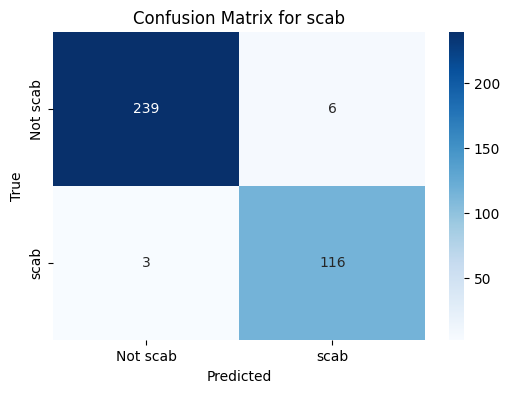

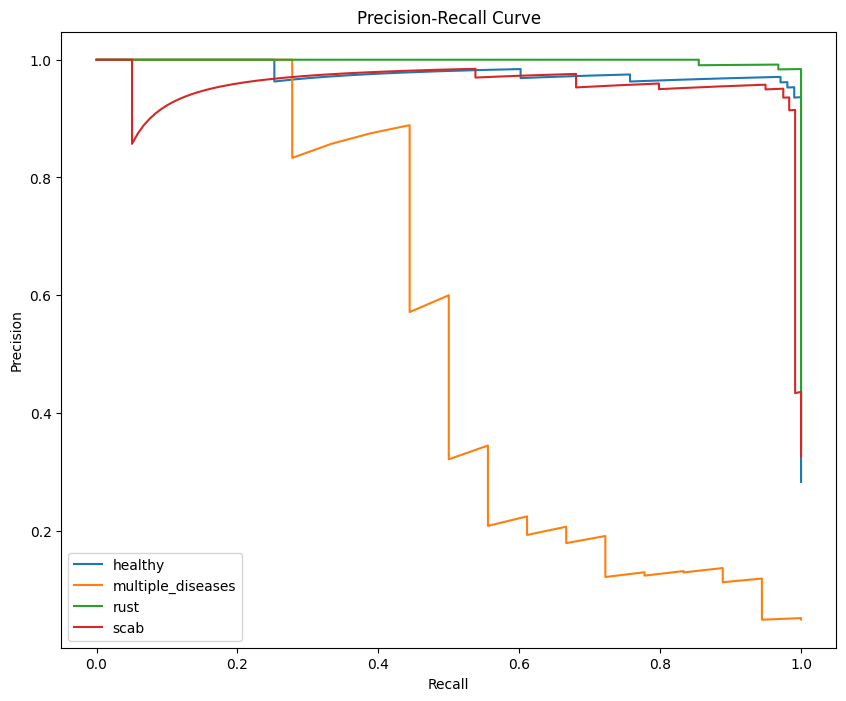

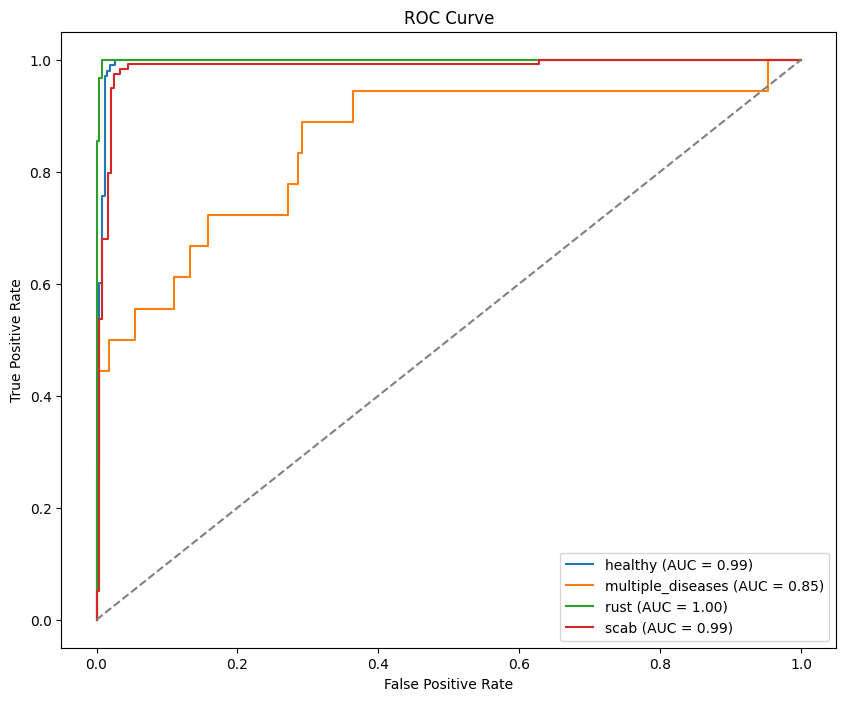


Training fold 3...
Epoch 1/15 - Fold 3
Training Loss: 1.0305, Validation Loss: 0.9723, Validation Accuracy: 0.7898
Epoch 2/15 - Fold 3
Training Loss: 0.9304, Validation Loss: 0.8807, Validation Accuracy: 0.8338
Epoch 3/15 - Fold 3
Training Loss: 0.8210, Validation Loss: 0.7601, Validation Accuracy: 0.8832
Epoch 4/15 - Fold 3
Training Loss: 0.7202, Validation Loss: 0.6458, Validation Accuracy: 0.9073
Epoch 5/15 - Fold 3
Training Loss: 0.5689, Validation Loss: 0.5442, Validation Accuracy: 0.9306
Epoch 6/15 - Fold 3
Training Loss: 0.5334, Validation Loss: 0.4875, Validation Accuracy: 0.9409
Epoch 7/15 - Fold 3
Training Loss: 0.4944, Validation Loss: 0.4538, Validation Accuracy: 0.9423
Epoch 8/15 - Fold 3
Training Loss: 0.4082, Validation Loss: 0.4119, Validation Accuracy: 0.9512
Epoch 9/15 - Fold 3
Training Loss: 0.3044, Validation Loss: 0.4271, Validation Accuracy: 0.9622
Epoch 10/15 - Fold 3
Training Loss: 0.3983, Validation Loss: 0.5130, Validation Accuracy: 0.9622
Epoch 11/15 - Fold 

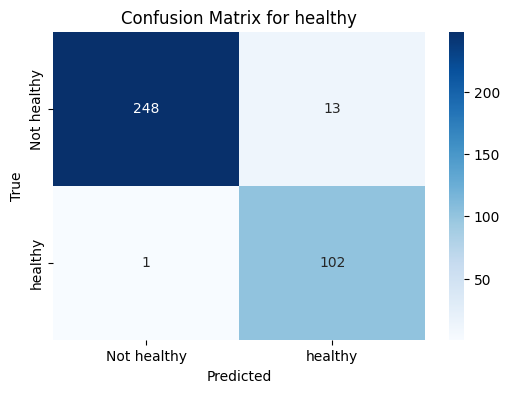


Metrics for class: multiple_diseases
  True Positives (TP): 6
  False Positives (FP): 4
  False Negatives (FN): 13
  True Negatives (TN): 341
  Precision: 0.6000
  Recall: 0.3158
  F1-score: 0.4138


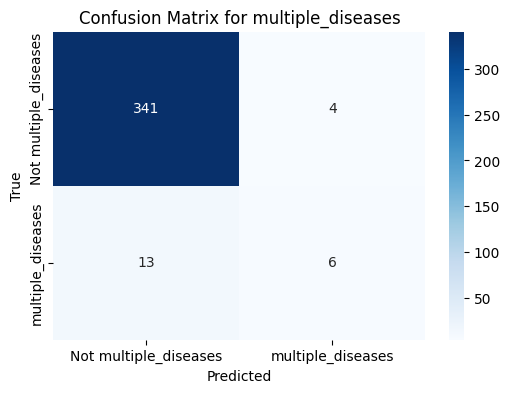


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 5
  False Negatives (FN): 0
  True Negatives (TN): 235
  Precision: 0.9612
  Recall: 1.0000
  F1-score: 0.9802


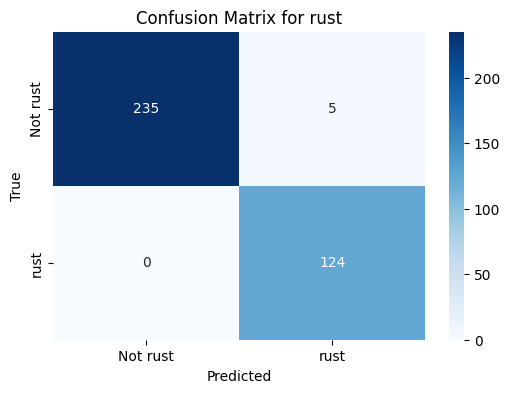


Metrics for class: scab
  True Positives (TP): 111
  False Positives (FP): 6
  False Negatives (FN): 7
  True Negatives (TN): 240
  Precision: 0.9487
  Recall: 0.9407
  F1-score: 0.9447


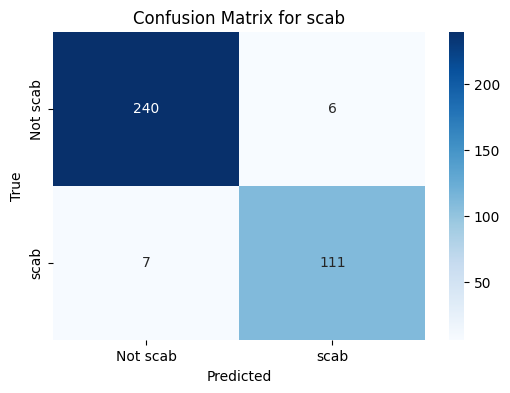

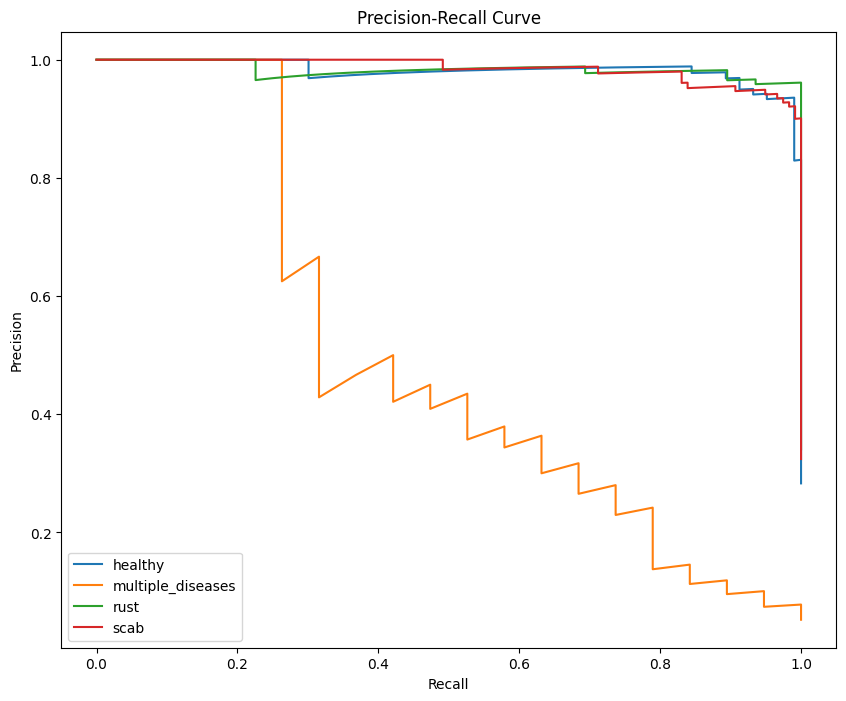

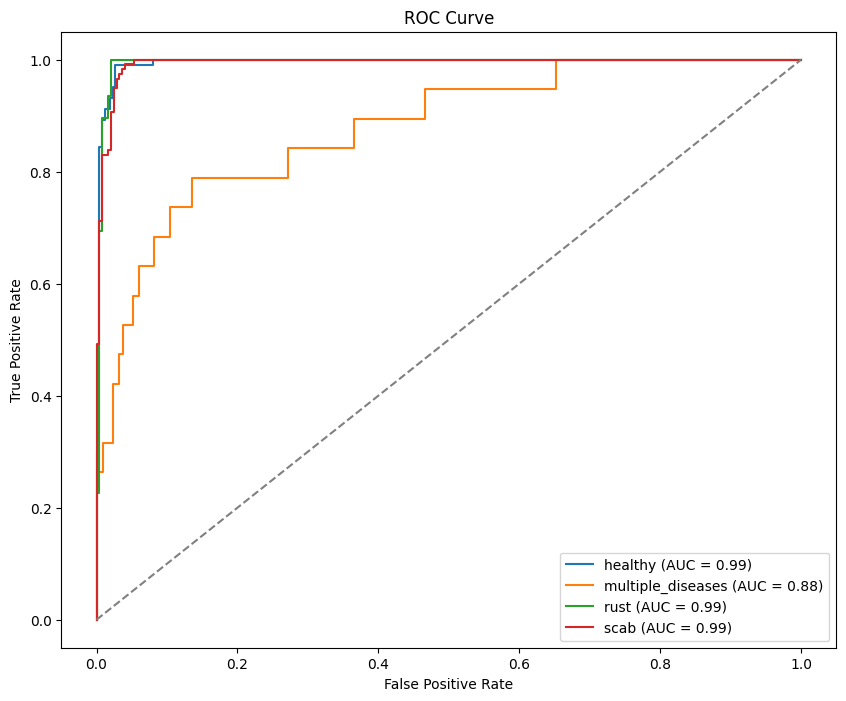


Training fold 4...
Epoch 1/15 - Fold 4
Training Loss: 1.0394, Validation Loss: 0.9725, Validation Accuracy: 0.6731
Epoch 2/15 - Fold 4
Training Loss: 0.9529, Validation Loss: 0.8805, Validation Accuracy: 0.8029
Epoch 3/15 - Fold 4
Training Loss: 0.8509, Validation Loss: 0.7576, Validation Accuracy: 0.8695
Epoch 4/15 - Fold 4
Training Loss: 0.7351, Validation Loss: 0.6322, Validation Accuracy: 0.9038
Epoch 5/15 - Fold 4
Training Loss: 0.6339, Validation Loss: 0.5297, Validation Accuracy: 0.9238
Epoch 6/15 - Fold 4
Training Loss: 0.5412, Validation Loss: 0.4443, Validation Accuracy: 0.9354
Epoch 7/15 - Fold 4
Training Loss: 0.4640, Validation Loss: 0.3925, Validation Accuracy: 0.9437
Epoch 8/15 - Fold 4
Training Loss: 0.4690, Validation Loss: 0.3542, Validation Accuracy: 0.9560
Epoch 9/15 - Fold 4
Training Loss: 0.4664, Validation Loss: 0.3773, Validation Accuracy: 0.9560
Epoch 10/15 - Fold 4
Training Loss: 0.3024, Validation Loss: 0.3044, Validation Accuracy: 0.9677
Epoch 11/15 - Fold 

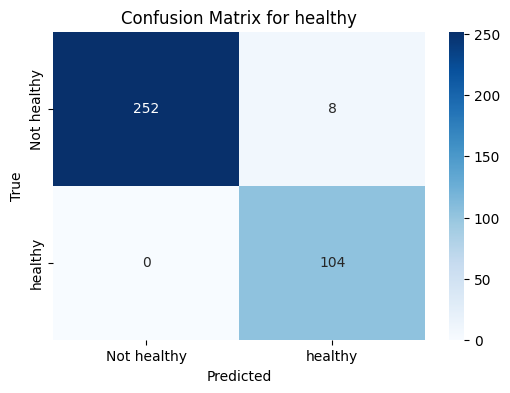


Metrics for class: multiple_diseases
  True Positives (TP): 5
  False Positives (FP): 3
  False Negatives (FN): 13
  True Negatives (TN): 343
  Precision: 0.6250
  Recall: 0.2778
  F1-score: 0.3846


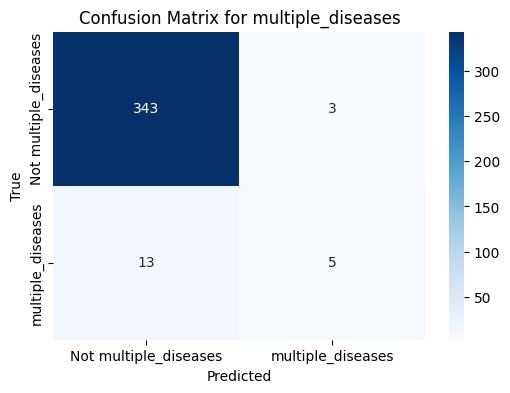


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 11
  False Negatives (FN): 0
  True Negatives (TN): 229
  Precision: 0.9185
  Recall: 1.0000
  F1-score: 0.9575


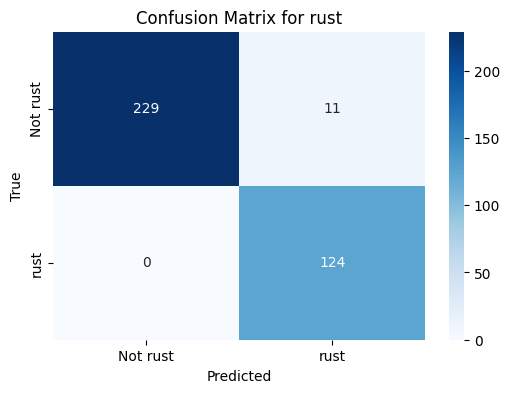


Metrics for class: scab
  True Positives (TP): 115
  False Positives (FP): 6
  False Negatives (FN): 3
  True Negatives (TN): 240
  Precision: 0.9504
  Recall: 0.9746
  F1-score: 0.9623


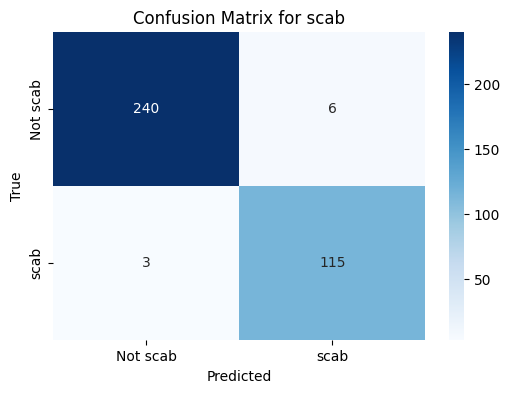

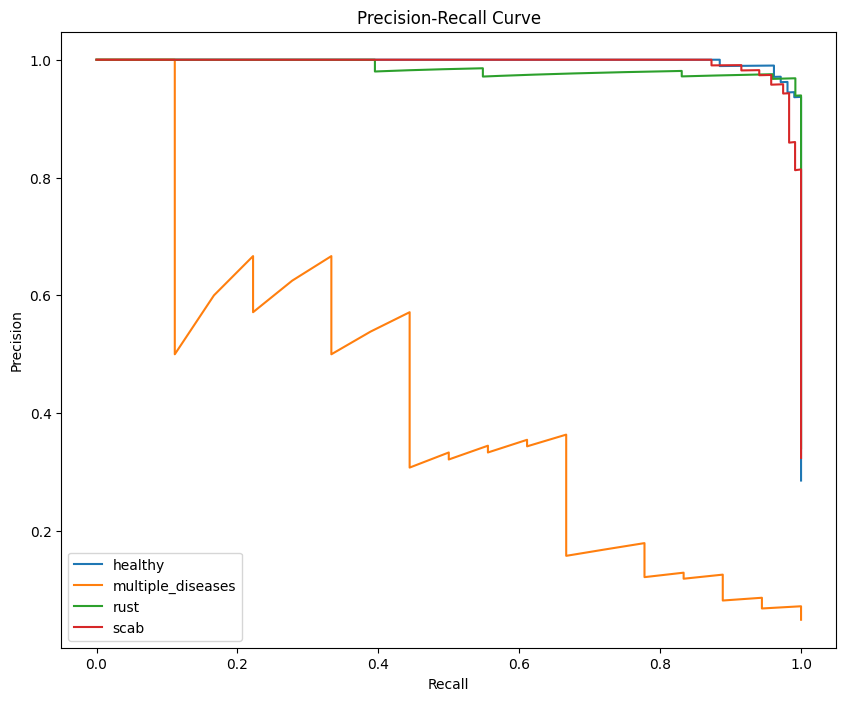

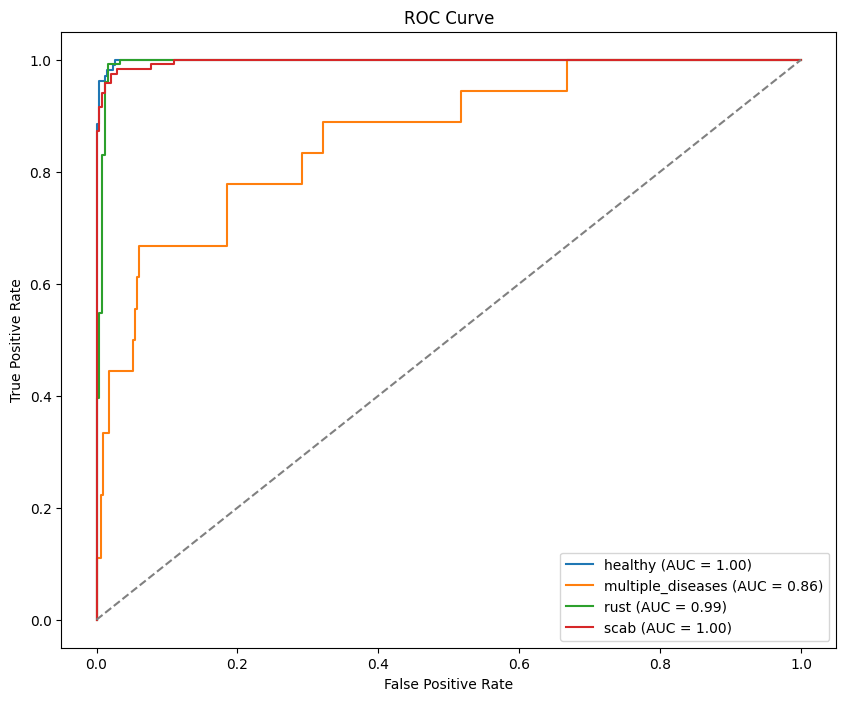


Training fold 5...
Epoch 1/15 - Fold 5
Training Loss: 1.0278, Validation Loss: 0.9868, Validation Accuracy: 0.7376
Epoch 2/15 - Fold 5
Training Loss: 0.9440, Validation Loss: 0.8944, Validation Accuracy: 0.8022
Epoch 3/15 - Fold 5
Training Loss: 0.8303, Validation Loss: 0.7741, Validation Accuracy: 0.8530
Epoch 4/15 - Fold 5
Training Loss: 0.7337, Validation Loss: 0.6725, Validation Accuracy: 0.8887
Epoch 5/15 - Fold 5
Training Loss: 0.5937, Validation Loss: 0.5501, Validation Accuracy: 0.9114
Epoch 6/15 - Fold 5
Training Loss: 0.5724, Validation Loss: 0.4800, Validation Accuracy: 0.9258
Epoch 7/15 - Fold 5
Training Loss: 0.4691, Validation Loss: 0.4590, Validation Accuracy: 0.9341
Epoch 8/15 - Fold 5
Training Loss: 0.3735, Validation Loss: 0.4287, Validation Accuracy: 0.9423
Epoch 9/15 - Fold 5
Training Loss: 0.3386, Validation Loss: 0.3969, Validation Accuracy: 0.9602
Epoch 10/15 - Fold 5
Training Loss: 0.4605, Validation Loss: 0.3968, Validation Accuracy: 0.9560
Epoch 11/15 - Fold 

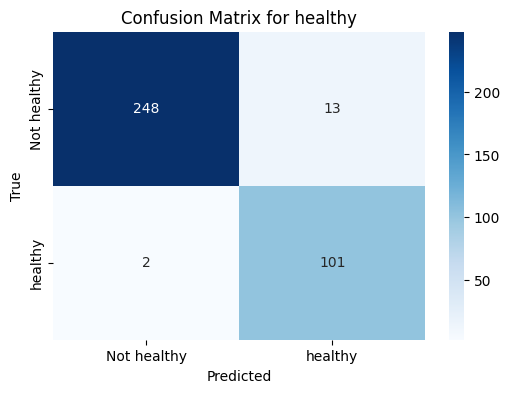


Metrics for class: multiple_diseases
  True Positives (TP): 5
  False Positives (FP): 2
  False Negatives (FN): 13
  True Negatives (TN): 344
  Precision: 0.7143
  Recall: 0.2778
  F1-score: 0.4000


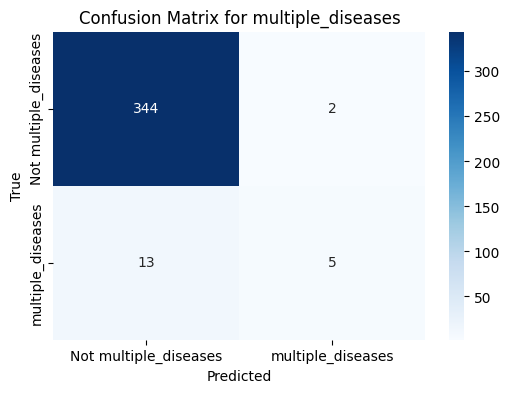


Metrics for class: rust
  True Positives (TP): 124
  False Positives (FP): 12
  False Negatives (FN): 1
  True Negatives (TN): 227
  Precision: 0.9118
  Recall: 0.9920
  F1-score: 0.9502


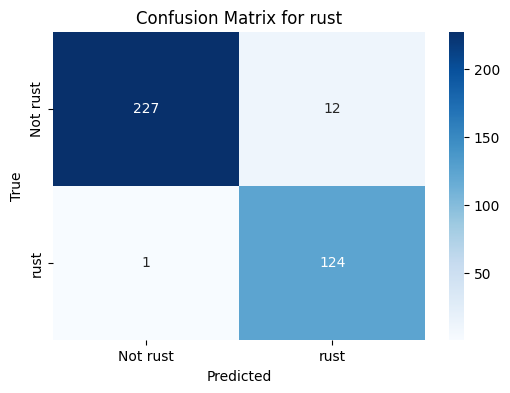


Metrics for class: scab
  True Positives (TP): 111
  False Positives (FP): 5
  False Negatives (FN): 7
  True Negatives (TN): 241
  Precision: 0.9569
  Recall: 0.9407
  F1-score: 0.9487


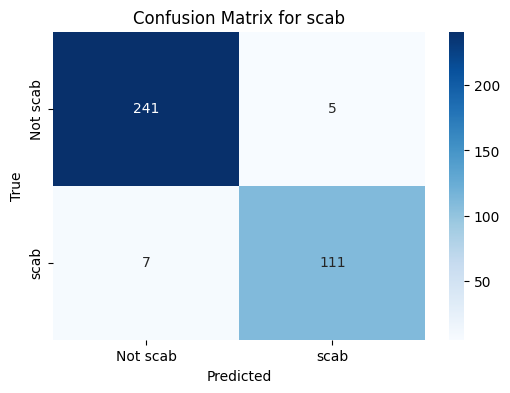

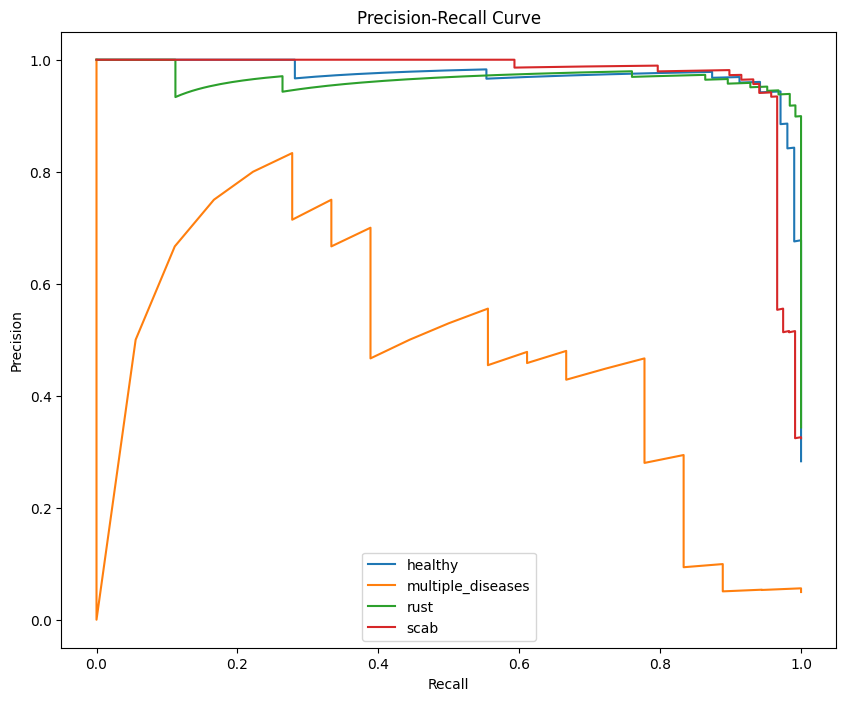

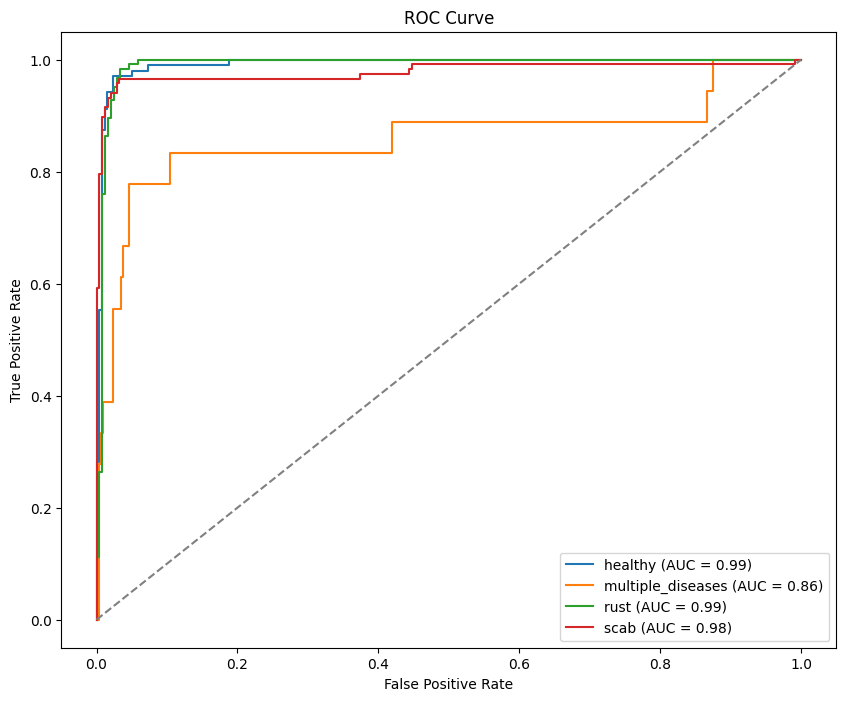

Kaggle submission file 'submission.csv' generated successfully!
  image_id   healthy  multiple_diseases      rust      scab
0   Test_0  0.031365           0.131009  0.976069  0.022444
1   Test_1  0.039643           0.058549  0.976364  0.030335
2   Test_2  0.028755           0.027318  0.018449  0.990600
3   Test_3  0.980400           0.041380  0.041431  0.035724
4   Test_4  0.047773           0.078137  0.974384  0.030987


In [13]:
from sklearn.model_selection import StratifiedKFold
from torchvision import models, transforms
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.nn import BCEWithLogitsLoss
from copy import deepcopy

# Data augmentation for better generalization
# V8->V9 lessened the strength of augmentation
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Apply validation transforms to test dataset
test_data.transform = val_transform

# Create test DataLoader
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Model initialization
# Upgraded to resnet34 from resnet18 because was hitting limits of model capacity
def initialize_model():
    model = models.resnet34()
    # Construct the full path to the .pth file inside the downloaded directory
    weights_file_path = os.path.join(rnapark_resnet34_b627a593_pth_path, 'resnet34-b627a593.pth')
    state_dict = torch.load(weights_file_path, map_location="cpu")
    model.load_state_dict(state_dict)
    # Added dropout layer
    model.fc = torch.nn.Sequential(
        torch.nn.Linear(model.fc.in_features, 512),
        torch.nn.ReLU(),
        torch.nn.Dropout(0.5),
        torch.nn.Linear(512, 4)  # Output layer
    )
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare labels and class weights
y_single = [np.argmax(sample[1]) for sample in train_data]  # For stratification
all_labels = torch.stack([torch.tensor(sample[1], dtype=torch.float32) for sample in train_data])
pos = all_labels.sum(dim=0)
neg = all_labels.shape[0] - pos
pos_weight = (neg / (pos + 1e-5)).to(device)

# K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Variables to track training and predictions
all_train_losses = []
all_val_accuracies = []
fold_accuracies = []
fold_test_predictions = []  # <- Store test predictions per fold

# K-Fold training loop
for fold, (train_idx, val_idx) in enumerate(skf.split(train_data, y_single)):
    print(f"\nTraining fold {fold + 1}...")

    # Deepcopy datasets to avoid transform overwrite
    train_dataset = deepcopy(train_data)
    val_dataset   = deepcopy(train_data)
    train_dataset.transform = train_transform
    val_dataset.transform   = val_transform

    # Build DataLoaders for this fold
    train_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(train_dataset, train_idx),
                                                    batch_size=64, shuffle=True)
    val_loader_fold = torch.utils.data.DataLoader(torch.utils.data.Subset(val_dataset, val_idx),
                                                  batch_size=64, shuffle=False)

    # Initialize model, optimizer, scheduler
    model = initialize_model().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=2e-4,
        epochs=15,
        steps_per_epoch=len(train_loader_fold),
        pct_start=0.2,
        div_factor=10,
        final_div_factor=100
    )
    loss_fn = BCEWithLogitsLoss(pos_weight=pos_weight, reduction="mean")
    patience = 5

    best_val_loss = float('inf')
    best_val_accuracy = 0
    epochs_without_improvement = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    # 15 epochs training
    for epoch in range(15):
        print(f"Epoch {epoch+1}/15 - Fold {fold+1}")
        train_loss = train_loop(train_loader_fold, model, loss_fn, optimizer, device, smoothing=0.0)
        val_loss, val_accuracy = evaluate_model(val_loader_fold, model, loss_fn, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        scheduler.step()

    fold_accuracies.append(best_val_accuracy)
    all_train_losses.extend(train_losses)
    all_val_accuracies.extend(val_accuracies)

    # Separate thresholds for each class (adjust thresholds as needed)
    #thresholds = [0.5, 0.6, 0.4, 0.7]  # Example thresholds for each class
    # Updated thresholds, prioritize improving F1 score
    #thresholds = [0.6, 0.7, 0.4, 0.5]
    # thresholds = [0.6, 0.65, 0.4, 0.45]
    # thresholds = [0.5, 0.55, 0.45, 0.45]
    thresholds = [0.5, 0.6, 0.4, 0.45] # 1, 3, 4 are fixed now, 0.6 better than 0.55, 0.65

    # Get predictions and probabilities from the validation set
    y_true, y_probs = predict_loop(val_loader_fold, model, device)

    # Apply the thresholds: convert probabilities to binary predictions per class
    # This will apply different thresholds to each class
    y_pred = (y_probs >= torch.tensor(thresholds).to(y_probs.device))  # Compare each class prob with its threshold
    y_pred = y_pred.int().numpy()  # Convert boolean to int (0 or 1)

    # Plot confusion matrix and other metrics
    plot_confusion_matrix(y_true.numpy(), y_pred, ['healthy','multiple_diseases','rust','scab'])
    plot_precision_recall_curve(y_true.numpy(), y_probs.numpy(), ['healthy','multiple_diseases','rust','scab'])
    plot_roc_curve(y_true.numpy(), y_probs.numpy(), ['healthy','multiple_diseases','rust','scab'])

    # Generate predictions on the test set for this fold using predict_test_loop
    fold_pred = predict_test_loop(test_loader, model, device)

    # Store the raw probabilities for later averaging
    fold_test_predictions.append(fold_pred)

# After all folds: average predictions
avg_test_predictions = torch.stack(fold_test_predictions).mean(dim=0).cpu()
predictions_np = avg_test_predictions.numpy()
# Build submission DataFrame
submission_columns = ['healthy', 'multiple_diseases', 'rust', 'scab']
submission_df = pd.DataFrame(predictions_np, columns=submission_columns)
submission_df.insert(0, 'image_id', test_data.data['image_id'].tolist())

submission_file_path = 'submission.csv'
submission_df.to_csv(submission_file_path, index=False)
print(f"Kaggle submission file '{submission_file_path}' generated successfully!")
print(submission_df.head())

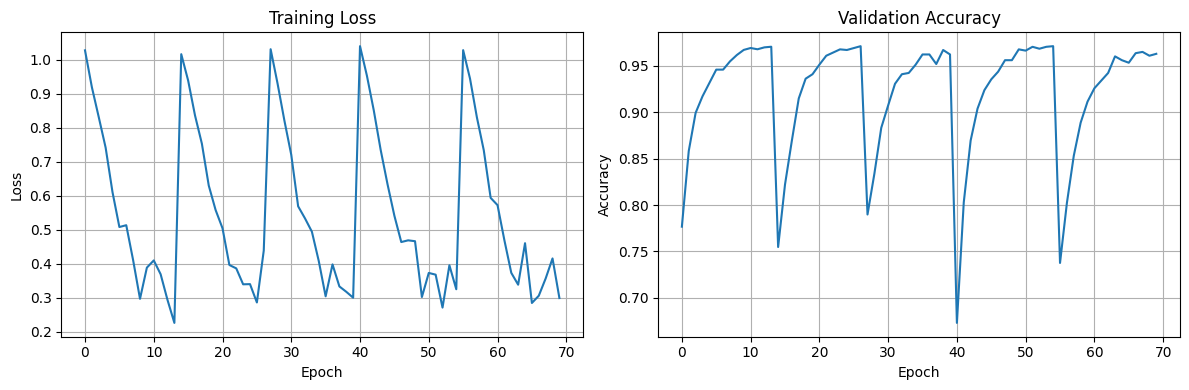


Average Validation Accuracy across all folds: 0.9613


In [14]:
# Plot training curves and report accuracy
plot_training_curves(all_train_losses, all_val_accuracies)
mean_val_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"\nAverage Validation Accuracy across all folds: {mean_val_accuracy:.4f}")